In [ ]:
!pip install d2l

In [ ]:
import os
import tensorflow as tf
from d2l import tensorflow as d2l
import numpy as np

In [ ]:
d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip',
                           '94646ad1522d915e7b0f9296181140edcf86a4f5')

def read_data_nmt():
    """Load the English-French dataset."""
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r') as f:
        return f.read()

raw_text = read_data_nmt()
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



In [ ]:
def preprocess_nmt(text):
    """Preprocess the English-French dataset."""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '

    # Replace non-breaking space with space, and convert uppercase letters to
    # lowercase ones
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # Insert space between words and punctuation marks
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)

text = preprocess_nmt(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


In [ ]:
def tokenize_nmt(text, num_examples=None):
    """Tokenize the English-French dataset."""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

source, target = tokenize_nmt(text)
source[:6], target[:6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

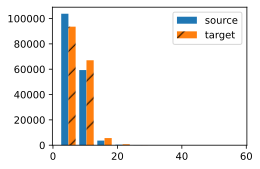

In [ ]:
d2l.set_figsize()
_, _, patches = d2l.plt.hist(
    [[len(l) for l in source], [len(l) for l in target]],
    label=['source', 'target'])
for patch in patches[1].patches:
    patch.set_hatch('/')
d2l.plt.legend(loc='upper right');

In [ ]:
src_vocab = d2l.Vocab(source, min_freq=2,
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)

10012

In [ ]:
def truncate_pad(line, num_steps, padding_token):
    """Truncate or pad sequences."""
    if len(line) > num_steps:
        return line[:num_steps]  # Truncate
    return line + [padding_token] * (num_steps - len(line))  # Pad

truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[3919, 80, 208, 208, 208, 208, 208, 208, 208, 208]

In [ ]:
def build_array_nmt(lines, vocab, num_steps):
    """Transform text sequences of machine translation into minibatches."""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = np.array([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).astype(np.int32).sum(1)
    return array, valid_len

In [ ]:
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """Return the iterator and the vocabularies of the translation dataset."""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

In [ ]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', tf.cast(X, tf.int32))
    print('valid lengths for X:', X_valid_len)
    print('Y:', tf.cast(Y, tf.int32))
    print('valid lengths for Y:', Y_valid_len)
    break

X: tf.Tensor(
[[ 81  20 183   2   4   5   5   5]
 [ 59  75   2   4   5   5   5   5]], shape=(2, 8), dtype=int32)
valid lengths for X: tf.Tensor([5 4], shape=(2,), dtype=int64)
Y: tf.Tensor(
[[100 194  68 144   2   4   5   5]
 [156  44 194   2   4   5   5   5]], shape=(2, 8), dtype=int32)
valid lengths for Y: tf.Tensor([6 5], shape=(2,), dtype=int64)


# Resposta 1
Ao observar o gráfico, podemos perceber que o tamanho do vocabulário tem um crescimento rápido no início junto com o aumento de valores de exemplo, até um momento que se cria um plato.

O cresimento acontece porque quando temos poucas frases de exemplo, realmente não vamos ter uma variedade em palavras. Ao aumentar cada vez mais o número de exemplo, mais palavras ainda desconhecidas vão aparecendo. Entretanto, a quantidade de palavras novas vai diminuindo conforme temos mais exemplos, porque muitas palavras vão se repetir.


In [ ]:
def resposta1(text, n_exemples):
    source, target = tokenize_nmt(text, n_exemples)
    src_vocab = d2l.Vocab(source, min_freq=2,
                              reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    return src_vocab, tgt_vocab

In [ ]:
i = 100
src_list = []
tgt_list = []
steps = []
while i < 1000000:
    src_vocab, tgt_vocab = resposta1(text, i)
    src_list.append(len(src_vocab))
    tgt_list.append(len(tgt_vocab))
    steps.append(i)
    i *= 2

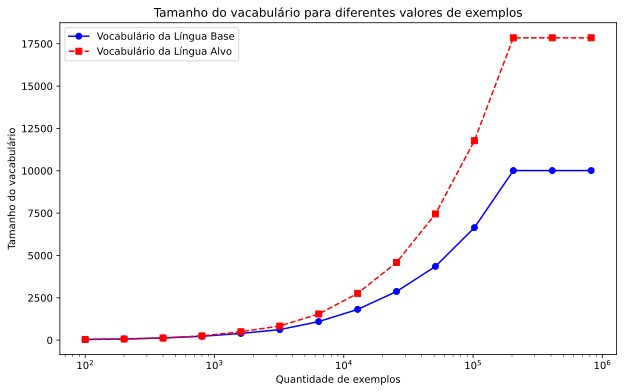

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

plt.plot(steps, src_list, marker='o', linestyle='-', color='b', label='Vocabulário da Língua Base')
plt.plot(steps, tgt_list, marker='s', linestyle='--', color='r', label='Vocabulário da Língua Alvo')

plt.xscale('log')

plt.xlabel('Quantidade de exemplos')
plt.ylabel('Tamanho do vacabulário')
plt.title('Tamanho do vacabulário para diferentes valores de exemplos')
plt.legend()

plt.show()

# Resposta 2
Para esses casos, se usa uma abordagem com base em caracteres ou em morfemas. A maioria dos tokenizers em japonês usam uma estrutura de grafo com possíveis substrings a partir do texto de entrada e um custo associado a elas. Depois se usa o algoritmo de viterbi para calcular qual a sequência de estados escondidos até o nó n que gera o menor custo.

Referência: https://towardsdatascience.com/how-japanese-tokenizers-work-87ab6b256984